# Quantum relaxation of H3S
Sulfur hydrate is one of the most interesting system of physics, it is one of the highest Tc ever measured (203 K).
Thanks to the very light mass of hydrogen atoms, its physical properties are dominated by anharmonicity and quantum fluctuations, making it the on of the best systems to be tackled with self-consistent harmonic approximation.

In this simple tutorial we will learn how to run an automatic quantum relaxation. 
We will follow the lines of these works: [Errea et al. Nature volume 532, pages81–84(2016)](https://www.nature.com/articles/nature17175) and [Bianco et al Phys. Rev. B 97, 214101](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.97.214101).

I provide the H3S.scf file, that contains the lattice and the atomic position of the high symmetry phase of H3S. 
The harmonic dynamical matrix are given as computed by quantum espresso, however, they can be recomputed live by running the get_phonons.py script (needs ASE and quantum-espresso phonon package).

You will see that also this case has an instability at gamma, with a phonon mode that is imaginary.

# How to automatize the relaxation
In the first PbTe tutorial we saw how to prepare the SSCHA calculation from scratch and how to manipulate ensembles and the
minimization.
However, all the procedure could be a bit clumsy. In this section I will show how to automatize everything.
We will complete the PbTe simulation to get some usefull results.

The automatic relaxation is performed through the Relax module, that implements two classes, one for the static cell relaxation and the other for the variable cell relaxation

In [1]:
%matplotlib notebook

In [2]:
# Import ASE to setup the automatic calculator
import ase
from ase.calculators.espresso import Espresso

# Lets import cellconstructor
import cellconstructor as CC
import cellconstructor.Phonons

# Import the sscha
import sscha, sscha.Ensemble, sscha.Relax, sscha.SchaMinimizer

from numpy import *
import numpy as np
import matplotlib.pyplot as plt

plt.ion() #Setup interactive plot mode

To make everything clear, we will start again from the harmonic dynamical matrix for our structure:

    matdyn
    
We need to impose the sum rule and to force it to be positive definite before starting a SSCHA calculation

In [3]:
pseudo = {"H":"H.pbe-rrkjus_psl.1.0.0.UPF",
         "S" : "S.pbe-nl-rrkjus_psl.1.0.0.UPF"}

input_data = {"ecutwfc" : 35,
              "ecutrho" : 350,
              "occupations" : "smearing",
              "input_dft" : "blyp",
              "mixing_beta" : 0.2,
              "conv_thr" : 1e-9,
              "degauss" : 0.02,
              "smearing" : "mp",
              "pseudo_dir" : ".",
             "tprnfor" : True}


espresso_calc = Espresso(pseudopotentials =pseudo,
                        input_data = input_data,
                        kspacing = 0.06,
                        koffset = (1,1,1))

In [4]:
# Let us load the starting dynamical matrix
dyn = CC.Phonons.Phonons("dyn_pop4_", nqirr = 3)

# Apply the sum rule and delete the imaginary modes
dyn.Symmetrize()
dyn.ForcePositiveDefinite()

# Generate the ensemble and the minimizer objects
ensemble = sscha.Ensemble.Ensemble(dyn, 1000, supercell = dyn.GetSupercell())
minimizer = sscha.SchaMinimizer.SSCHA_Minimizer(ensemble)

# We setup all the minimization parameters
minimizer.min_step_dyn = 0.001
minimizer.kong_liu_ratio = 0.5

You can automatize also the cluster calculation by setting up a cluster object 
like we did in the previous tutorials.
If you keep it as None (as done in the following cell) the calculation will be runned locally.
Remember, if you use the cluster, you need to copy first the pseudopotential in the working directory of the cluster.

In [5]:
# Here we prepare a cluster
# Here we configure the cluster object MARCONI
import sscha.Cluster
my_hpc = sscha.Cluster.Cluster(pwd = None)

# We setup the connection info
my_hpc.hostname = "ekhi" # The command to connect via ssh to the cluster
#my_hpc.account_name = "IscrB_COMRED" # The name of the project for the computation
my_hpc.workdir = "/scratch/lorenzo/my_h3s_dir" # the directory in which the calculations are performed

# Now we need to setup the espresso
# First we must tell the cluster where to find him:
my_hpc.binary = "pw.x -npool NPOOL -i  PREFIX.pwi > PREFIX.pwo"
# Then we need to specify if some modules must be loaded in the submission script
my_hpc.load_modules = """
# Here this is a bash script at the beginning of the submission
# We can load modules

module load QuantumESPRESSO
export OMP_NUM_THREADS=1
"""

# All these information are independent from the calculation
# Now we need some more specific info, like the number of processors, pools and other stuff
my_hpc.n_cpu = 40 # We will use 32 processors
my_hpc.n_nodes = 1 #In 1 node
my_hpc.n_pool = 20 # This is an espresso specific tool, the parallel CPU are divided in 4 pools

# We can also choose in how many batch of jobs we want to submit simultaneously, and how many configurations for each job
my_hpc.batch_size = 10
my_hpc.job_number = 20
# In this way we submit 10 jobs, each one with 10 configurations (overall 100 configuration at time)

# We give 25 seconds of timeout
my_hpc.set_timeout(30)

# We can specify the time limit for each job,
my_hpc.time = "00:20:00" # 5 minutes

my_hpc.setup_workdir()

In [6]:
# We prepare the Automatic relaxation
relax = sscha.Relax.SSCHA(minimizer, ase_calculator = espresso_calc,
                         N_configs = 200,
                         max_pop = 6,
                         save_ensemble = True,
                         cluster = my_hpc)

Lets see the parameters:
    
    minimizer     : it is the SSCHA_Minimizer, containing the settings of each minimization.
    N_configs     : the number of configurations to generate at each run (we call them populations)
    max_pop       : The maximum number of populations after wich the calculation is stopped even if not converged.
    save_ensemble : If True, after each energy and force calculation, the ensemble will be saved.
    cluster       : The cluster object to be used for submitting the configurations.
    

If no cluster is provided (like in this case) the calculation is performed locally.
The save_ensemble keyword will dave the ensemble inside the directory specified in the running command
```python
relax.relax(ensemble_loc = "directory_of_the_ensemble")
```

The calculation can be runned just by calling
```python
relax.relax()
```
And the code will proceed with the automatic SSCHA minimization.
However, before doing so, we will setup a custom function.
These are usefull to manipulate a bit the minimization, printing or saving extra info
during the minimization.
In particular, we will setup a function to be called after each minimization step of each population, that
will save the current frequencies of the auxiliary dynamical matrix in an array, so that we will be able
to plot the whole frequency evolution after the minimization.

The following cell will start the computation. Consider that it may take long time.
Running espresso in parallel with 4 processrs on a Intel(R) Core(TM) i7-4790K CPU at 4.00GHz the single ab-initio run takes a bit more than 1 minute. In this example we are running 20 configurations per population and up to 6 populations. 
So the overall time is about 2 hours and half.

For hevier relaxations it is strongly suggested to use the cluster module, or to directly run the SSCHA from a more powerful computer.

Thansk to the line inside our custom function
```python
np.savetxt("all_frequencies.dat", all_frequencies)
```
we will save at each minimization step the evolution of the frequencies.
So we can load and plot them even during the minimization, to get a clue on how frequencies of the SSCHA dynamical matrix are evolving.

**NOTE**: These frequencies are not the physical frequencies of the phonon quasiparticles, but just the frequencies of the auxiliary dynamical matrix. To obtain the real physical frequencies, look at the StructuralInstability and the Dynamical spectral function tutorials.

In [ ]:
# We reset the frequency array
all_frequencies = []

# We define a function that will be called by the code after each minimization step, 
# passing to us the minimizer at that point
# We will store the frequencies, to plot after the minimization their evolution.
def add_current_frequencies(minimizer):
    # Get the frequencies
    w, p = minimizer.dyn.DiagonalizeSupercell()
    
    all_frequencies.append(w)
    
    # In this way the file will be updated at each step
    np.savetxt("all_frequencies.dat", all_frequencies)

# We add this function to the relax ojbect
relax.setup_custom_functions(custom_function_post = add_current_frequencies)

# Now we are ready to
# ***************** RUN *****************
relax.relax(ensemble_loc = "data_ensemble_autorelax")
# ***************************************

In [8]:
# We can save the frequency list for furture analisys
# NOTE: This will overwrite the one given in the examples!
np.savetxt("all_frequencies.dat", all_frequencies)

In [9]:
# Lets plot the minimization
relax.minim.plot_results()

<IPython.core.display.Javascript object>


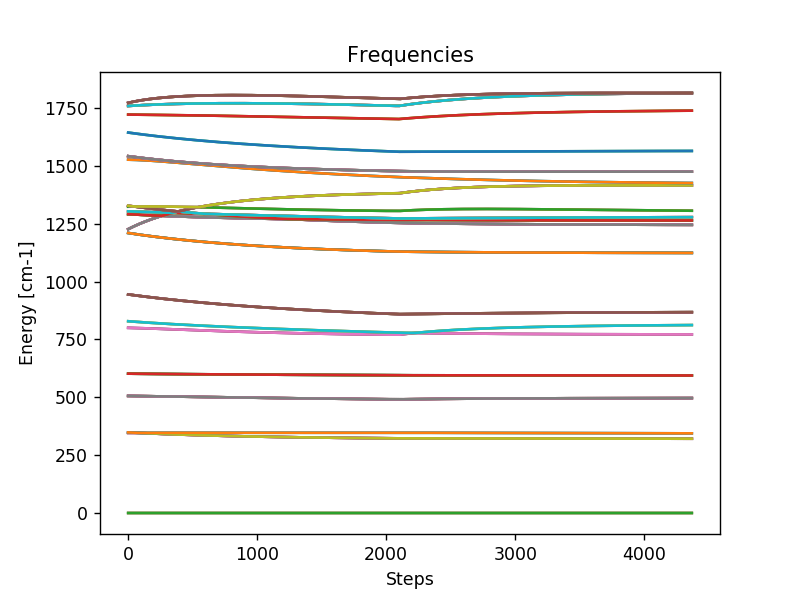

In [6]:
# Lets plot all the frequencies in their evolution
all_frequencies = np.loadtxt("all_frequencies.dat")
freqs = np.array(all_frequencies).T 
n_freqs = shape(freqs)[0]

plt.figure(dpi = 100)
plt.title("Frequencies")
plt.ylabel("Energy [cm-1]")
plt.xlabel("Steps")
for i in range(n_freqs):
    plt.plot(freqs[i, :] * CC.Units.RY_TO_CM)


# The Structural phase transition

We got the minimum of the free energy, now we can compute the free energy curvature around this high symmetry structure, to discover if there are some imaginary phonons. 
In order to do this, we need the the free energy hessian:

$$
\frac{\partial^2 F}{\partial R_a \partial R_b} \approx \Phi_{ab} + \sum_{pqrs}\stackrel{(3)}{\Phi}_{apq} \Lambda_{pqrs} \stackrel{(3)}{\Phi}_{rsb}
$$

This is obtained neglecting 4 phonon scattering (that may be relevant for highly anharmonic systems).

You can compute this quantity using the get_free_energy_hessian subroutine of the ensemble class.
However, you need a bigger ensemble to get reliable results. We will use the last ensemble, but for production calculations it is advisable to generate a new, bigger, ensemble.

Here, the flag include_v4 tells if you need to include the V4

In [12]:
# Compute the free energy hessian
free_energy_hessian = relax.minim.ensemble.get_free_energy_hessian(include_v4 = False)

In [14]:
# Now we can save the free energy hessian like it was a dynamical matrix
free_energy_hessian.save_qe("hessian")

# We can print its eigenvalues to see if there are imaginary phonons
w, p = free_energy_hessian.DiagonalizeSupercell()
print(w * CC.Units.RY_TO_CM)

[-3.86241653e-05 -2.54094408e-05  1.93744849e-05  3.13241198e+02
  3.13241198e+02  3.13241198e+02  3.13241198e+02  3.13241198e+02
  3.13241198e+02  3.30348694e+02  3.30348694e+02  3.30348694e+02
  4.15342661e+02  4.15342661e+02  4.15342661e+02  4.15342661e+02
  4.15342661e+02  4.15342661e+02  5.45615319e+02  5.45615319e+02
  5.45615319e+02  5.45615319e+02  5.45615319e+02  5.45615319e+02
  7.42041373e+02  7.42041373e+02  7.42041373e+02  7.52648326e+02
  7.52648326e+02  7.52648326e+02  8.43506806e+02  8.43506806e+02
  8.43506806e+02  8.43506806e+02  8.43506806e+02  8.43506806e+02
  1.08903503e+03  1.08903503e+03  1.08903503e+03  1.08903503e+03
  1.08903503e+03  1.08903503e+03  1.20924095e+03  1.20924095e+03
  1.20924095e+03  1.21606945e+03  1.21606945e+03  1.21606945e+03
  1.21606945e+03  1.21606945e+03  1.21606945e+03  1.22775643e+03
  1.22775643e+03  1.22775643e+03  1.22775643e+03  1.22775643e+03
  1.22775643e+03  1.23314055e+03  1.23314055e+03  1.23314055e+03
  1.23314055e+03  1.23314

No imaginary phonon! The structure is stable at this pressure.

Remember, to get converged result, you should study this result as a function of the number of configurations and as a function of the supercell size!